<a href="https://colab.research.google.com/github/milicasopalovic/RI_rokovi/blob/main/mobile_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!git clone https://gitlab.com/milicasopalovic/ip2-projekat.git

fatal: destination path 'ip2-projekat' already exists and is not an empty directory.


In [32]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix


In [33]:
trening_dir = './ip2-projekat/skup_podataka_original/trening'
test_dir = './ip2-projekat/skup_podataka_original/test'

batch_size = 32
img_height, img_width = 224, 224

# Kreiranje ImageDataGenerator-a sa normalizacijom
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

# Generator za trening (80% podataka)
train_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Deo za trening
)

# Generator za validaciju (20% podataka)
validation_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Deo za validaciju
)

# Generator za test skup (bez podele)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  #test ne mesamo
)


Found 1029 images belonging to 37 classes.
Found 240 images belonging to 37 classes.
Found 571 images belonging to 37 classes.


In [34]:
# Imena klasa i njihovi indeksi
imena_klasa = list(train_generator.class_indices.keys())
print("Klase:", imena_klasa)

# Prebrojavanje uzoraka po klasama
broj_uzoraka_po_klasi = train_generator.classes  # Lista klasa za svaku sliku
print("Broj uzoraka po klasama:", np.bincount(broj_uzoraka_po_klasi))

# Izračunavanje tezina klasa
tezine_klasa = compute_class_weight(
    class_weight='balanced',  # Balansiranje na osnovu broja uzoraka
    classes=np.unique(broj_uzoraka_po_klasi),
    y=broj_uzoraka_po_klasi
)
tezine_klasa = dict(enumerate(tezine_klasa))  # Konverzija u format koji fit() razume
print("Težine klasa:", tezine_klasa)

Klase: ['aenar', 'andorian', 'antedian', 'arcadian', 'arcturian', 'axanar', 'bajoran', 'benzite', 'bolian', 'borg', 'breen', 'brikar', 'cardassian', 'changeling', 'deltan', 'denobulan', 'dosi', 'ferengi', 'gorn', 'hirogen', 'human', "jem'Hadar", 'kazon', 'kelpien', 'klingon', 'orion', 'pakled', 'reman', 'romulan', 'talaxian', 'talosians', 'tellarite', 'trill', 'vidiians', 'vortas', 'vulcan', 'xindi']
Broj uzoraka po klasama: [ 32  37  16  15   9   4  42  24  51  32  22  24  44  36  35  30  17  60
  54  29 129  18  15  17  14  15  14  14  15  12  18  14  17  16  13  30
  45]
Težine klasa: {0: 0.8690878378378378, 1: 0.7516435354273192, 2: 1.7381756756756757, 3: 1.854054054054054, 4: 3.09009009009009, 5: 6.952702702702703, 6: 0.6621621621621622, 7: 1.1587837837837838, 8: 0.5453100158982512, 9: 0.8690878378378378, 10: 1.2641277641277642, 11: 1.1587837837837838, 12: 0.6320638820638821, 13: 0.7725225225225225, 14: 0.7945945945945946, 15: 0.927027027027027, 16: 1.6359300476947536, 17: 0.46351

In [35]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(37, activation='softmax')
])

In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_generator,
    epochs=20,  # Broj epoha
        class_weight=tezine_klasa,
        validation_data = validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - accuracy: 0.0658 - loss: 4.2574 - val_accuracy: 0.3083 - val_loss: 2.9916 - learning_rate: 0.0010
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.2538 - loss: 2.9278 - val_accuracy: 0.4500 - val_loss: 2.2326 - learning_rate: 0.0010
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.4341 - loss: 2.0547 - val_accuracy: 0.5208 - val_loss: 1.7667 - learning_rate: 0.0010
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5346 - loss: 1.5506 - val_accuracy: 0.5750 - val_loss: 1.5375 - learning_rate: 0.0010
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6682 - loss: 1.1533 - val_accuracy: 0.6500 - val_loss: 1.3041 - learning_rate: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7290 - loss: 0.8308 - val_accuracy: 0.6750 - val_loss: 1.2392 - learning_rate: 0.0010
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7692 - loss: 0.7424 - val

In [38]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.8298 - loss: 0.6488
Test gubitak: 0.7842
Test tačnost: 0.7758


In [39]:
# Predikcije modela za test skup
predikcije = np.argmax(model.predict(test_generator), axis=-1)


# Pretvaranje stvarnih vrednosti u indekse (ako su one u one-hot kodiranju)
stvarno = test_generator.classes

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Provera da li je matrica konfuzije dobro izračunata
print(f"Dimenzije matrice konfuzije: {matrica_konfuzije.shape}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step
Dimenzije matrice konfuzije: (37, 37)


In [40]:
model.save("mobile_net_originalni_skup.h5")

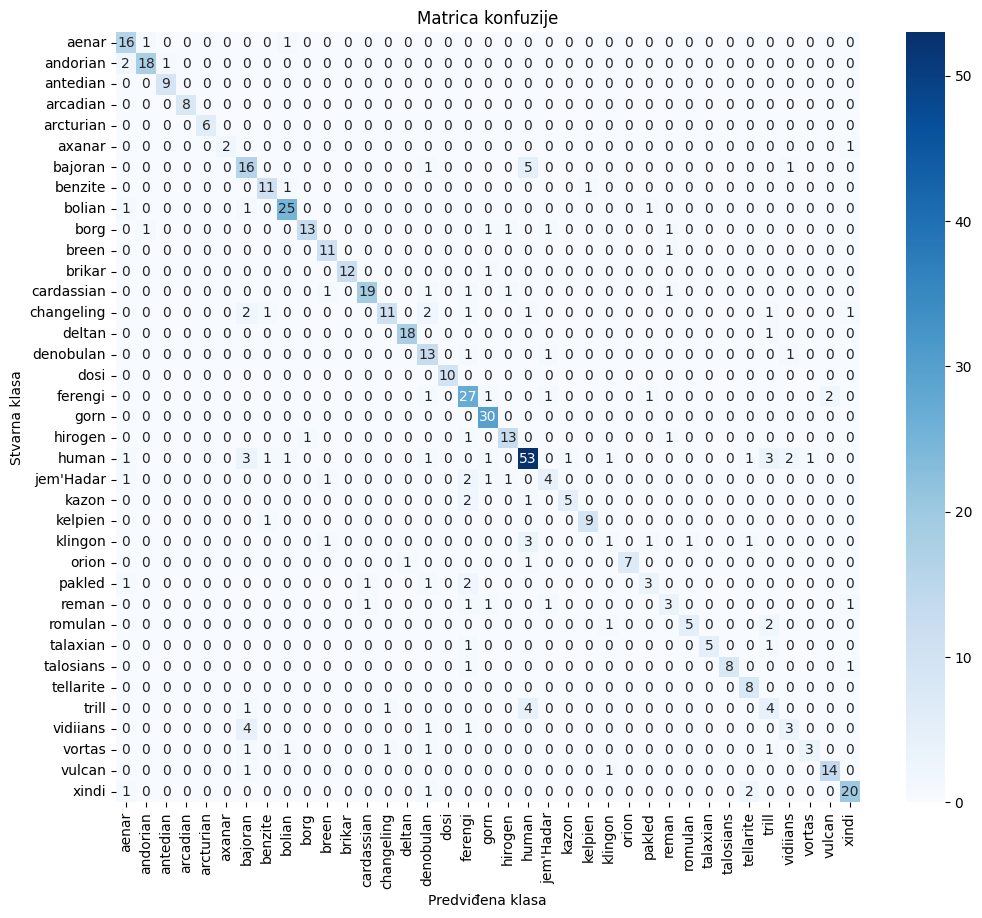

In [41]:
# Definisanje svih klasa
sortirani_nazivi_klasa = sorted(os.listdir(test_dir))
class_names = sortirani_nazivi_klasa  # Sortiranje klasa

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=class_names, columns=class_names)

# Prikazivanje matrice konfuzije
plt.figure(figsize=(12, 10))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

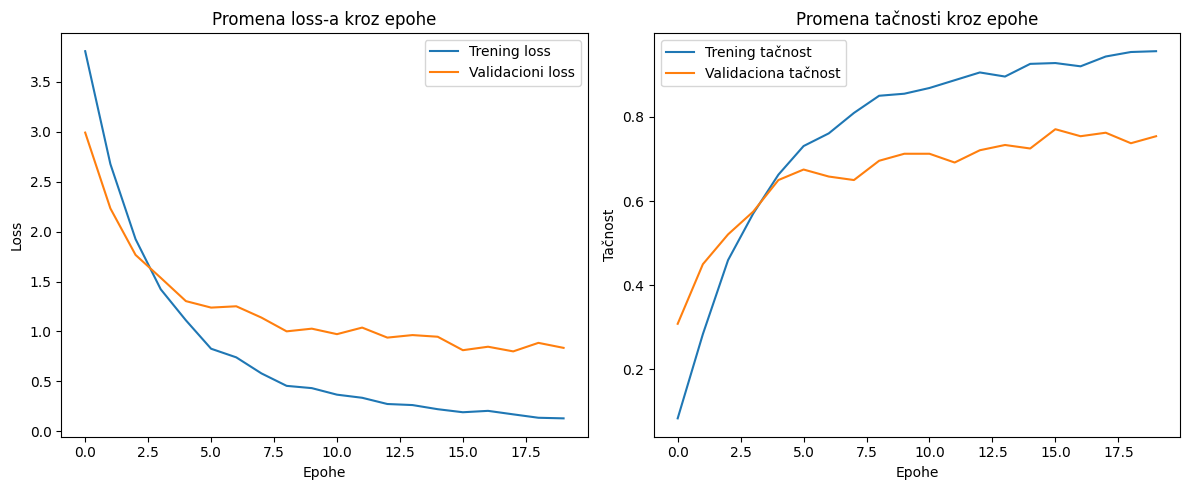

In [42]:
# Grafici loss-a i tačnosti
plt.figure(figsize=(12, 5))

# Loss grafikon
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trening loss')
plt.plot(history.history['val_loss'], label='Validacioni loss')
plt.title('Promena loss-a kroz epohe')
plt.xlabel('Epohe')
plt.ylabel('Loss')
plt.legend()

# Tačnost grafikon
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Trening tačnost')
plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
plt.title('Promena tačnosti kroz epohe')
plt.xlabel('Epohe')
plt.ylabel('Tačnost')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
trening_dir = './ip2-projekat/skup_podataka_vestacki/trening'
test_dir = './ip2-projekat/skup_podataka_vestacki/test'

batch_size = 32
img_height, img_width = 224, 224

# Kreiranje ImageDataGenerator-a sa normalizacijom
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

# Generator za trening (80% podataka)
train_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Deo za trening
)

# Generator za validaciju (20% podataka)
validation_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Nije potrebno mešanje
    subset='validation'  # Deo za validaciju
)

# Generator za test skup (bez podele)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Test ne mešamo da bismo dobili tačne metrike
)


Found 5000 images belonging to 37 classes.
Found 1231 images belonging to 37 classes.
Found 2843 images belonging to 37 classes.


In [44]:
history = model.fit(
    train_generator,
    epochs=20,  # Broj epoha
        validation_data = validation_generator,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.6253 - loss: 1.2988 - val_accuracy: 0.8229 - val_loss: 0.6202 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.7415 - loss: 0.8635 - val_accuracy: 0.8619 - val_loss: 0.4862 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8100 - loss: 0.6036 - val_accuracy: 0.8708 - val_loss: 0.4394 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.8573 - loss: 0.4803 - val_accuracy: 0.8976 - val_loss: 0.3634 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.8755 - loss: 0.4208 - val_accuracy: 0.9041 - val_loss: 0.3339 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.8824 - loss: 0.3646 - val_accuracy: 0.8757 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.9017 - loss: 0.320

In [45]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test gubitak: {test_loss:.4f}")
print(f"Test tačnost: {test_accuracy:.4f}")


89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8519 - loss: 0.6116
Test gubitak: 0.7259
Test tačnost: 0.8122


In [46]:
model.save("mobile_net_vestacki_generisani.h5")

In [47]:
# Predikcije modela za test skup
predikcije = np.argmax(model.predict(test_generator), axis=-1)


# Pretvaranje stvarnih vrednosti u indekse (ako su one u one-hot kodiranju)
stvarno = test_generator.classes

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Provera da li je matrica konfuzije dobro izračunata
print(f"Dimenzije matrice konfuzije: {matrica_konfuzije.shape}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step
Dimenzije matrice konfuzije: (37, 37)


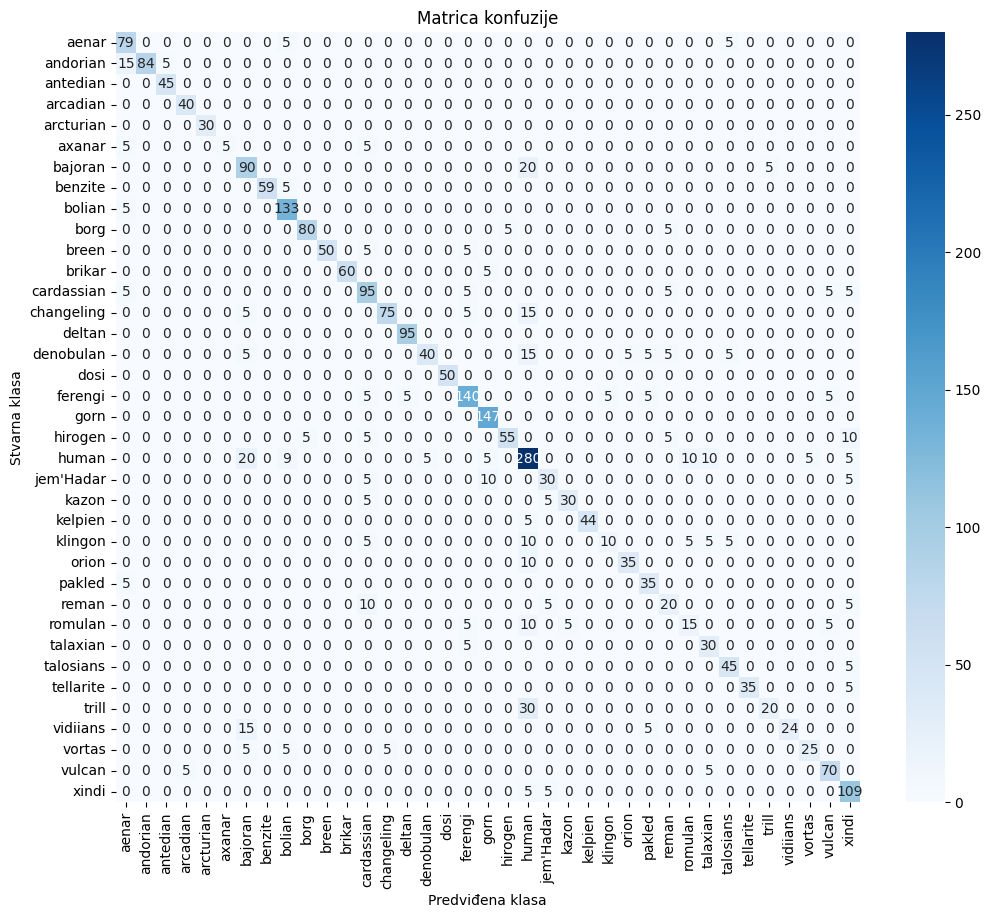

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definisanje svih klasa
sortirani_nazivi_klasa = sorted(os.listdir(test_dir))
class_names = sortirani_nazivi_klasa  # Sortiranje klasa

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=class_names, columns=class_names)

# Prikazivanje matrice konfuzije
plt.figure(figsize=(12, 10))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

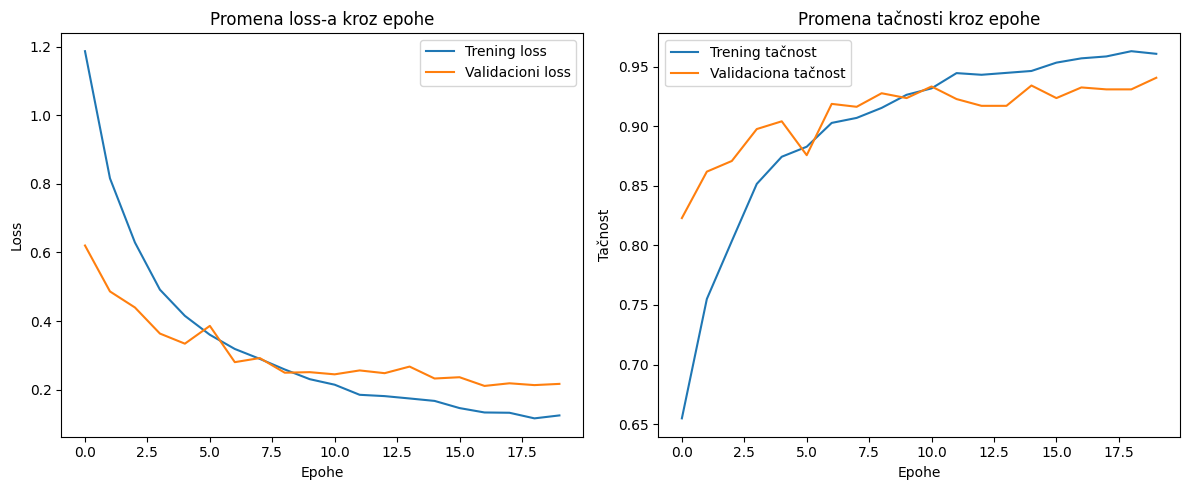

In [49]:
# Grafici loss-a i tačnosti
plt.figure(figsize=(12, 5))

# Loss grafikon
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trening loss')
plt.plot(history.history['val_loss'], label='Validacioni loss')
plt.title('Promena loss-a kroz epohe')
plt.xlabel('Epohe')
plt.ylabel('Loss')
plt.legend()

# Tačnost grafikon
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Trening tačnost')
plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
plt.title('Promena tačnosti kroz epohe')
plt.xlabel('Epohe')
plt.ylabel('Tačnost')
plt.legend()

plt.tight_layout()
plt.show()